# DEPRIVATION INDEX PREDICTION USING DEEP LEARNING

# Initial Setup: Getting the data from the Web and transfering to Drive

In [ ]:
!wget "https://uwoca-my.sharepoint.com/:u:/g/personal/cbravoro_uwo_ca/Ea8hL1Qqz-1DqXPUkFg3_OkBkT_oOJ5EdvwX1YU_afWF1w?download=1"

--2021-12-14 21:03:28--  https://uwoca-my.sharepoint.com/:u:/g/personal/cbravoro_uwo_ca/Ea8hL1Qqz-1DqXPUkFg3_OkBkT_oOJ5EdvwX1YU_afWF1w?download=1
Resolving uwoca-my.sharepoint.com (uwoca-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to uwoca-my.sharepoint.com (uwoca-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/cbravoro_uwo_ca/Documents/Clases/Western/FM%209528A%20Banking%20Analytics/2021/Coursework%203%20-%20Deep%20Learning/LiDARTiles.tar.gz [following]
--2021-12-14 21:03:29--  https://uwoca-my.sharepoint.com/personal/cbravoro_uwo_ca/Documents/Clases/Western/FM%209528A%20Banking%20Analytics/2021/Coursework%203%20-%20Deep%20Learning/LiDARTiles.tar.gz
Reusing existing connection to uwoca-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 3115530847 (2.9G) [application/x-gzip]
Saving to: ‘Ea8hL1Qqz-1DqXPUkFg3_OkBkT_oOJ5EdvwX1YU_afWF1w?download=1’

J5EdvwX1YU_afWF1w?d  13%[=

In [ ]:
!cp bankinga3data.tar.gz /content/drive/MyDrive/BankingA3data/

In [ ]:
!rm -rf /content/drive/MyDrive/BankingA3data/LIDAR

# Starting with the Analysis


# 1. Extracting the images and running checks


#### 1.1. Loading Images


In [4]:
home_directory = "/content/drive/MyDrive/BankingA3data"

In [ ]:
!tar -xvzf /content/drive/MyDrive/BankingA3data/bankinga3data.tar.gz


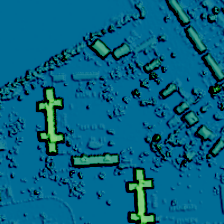

In [6]:
from IPython.display import Image
Image(filename='LIDAR/LIDAR_12004.png') 

In [7]:
#Checking the number of images
import glob, os
os.chdir("LIDAR")
print(len(glob.glob("*.png")))
os.chdir('../')

47360


1.2. Check for Monochromatic Images


In [8]:
from PIL import ImageStat
from PIL import Image as ImagePIL

MONOCHROMATIC_MAX_VARIANCE = 0.005

def is_monochromatic_image(src):
    v = ImageStat.Stat(ImagePIL.open(src)).var
    return reduce(lambda x, y: x and y < MONOCHROMATIC_MAX_VARIANCE, v, True)

In [9]:
from functools import reduce
monochrome_list=[]
for i in os.listdir('LIDAR/'):
  src = "LIDAR/"+i
  if is_monochromatic_image(src):
    monochrome_list.append(i)

In [10]:
print(len(monochrome_list),monochrome_list[5])

3069 LIDAR_57117.png


In [11]:
monochrome_list_loc = ['LIDAR/'+i for i in monochrome_list]

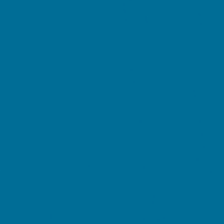

In [12]:
#Can be seen that this image is completely comprised of white pixels.

from IPython.display import Image
Image(filename='LIDAR/LIDAR_72255.png') 


#### 1.3. Loading Embeddings


In [13]:
import pandas as pd

In [14]:
#Loading the embedding data
embeddings = pd.read_csv(home_directory+'/EmbeddingData_C3_9528.csv')

In [15]:
embeddings.head(2)

,id,LSOA11CD,LSOA11NM,SOAC11CD,SOAC11NM,MSOA11CD,MSOA11NM,LAD17CD,LAD17NM,LACCD,LACNM,income,employment,education,health,crime,barriers,living_environment
0,48552,E01000759,Bromley 034A,8a,Affluent communities,E02000160,Bromley 034,E09000006,Bromley,1a1r,Rural-Urban Fringe,0.025,0.042,7.632,-1.345,-0.139,30.886,13.902
1,46571,E01000759,Bromley 034A,8a,Affluent communities,E02000160,Bromley 034,E09000006,Bromley,1a1r,Rural-Urban Fringe,0.025,0.042,7.632,-1.345,-0.139,30.886,13.902


In [16]:
embeddings[['crime']].describe()

,crime
count,36723.000000
mean,0.211408
std,0.588681
min,-2.354000
25%,-0.199000
50%,0.221000
75%,0.627000
max,2.377000


In [17]:
embeddings.shape

(36723, 18)

* It can be seen that the number of embeddings available is less than the number of LIDAR images that are present 

#### 1.3. Adding image locations to dataframe 

In [18]:
#Function to get image from embedding id
def get_image(id):
  file_name = 'LIDAR/LIDAR_'+str(id)+'.png'
  print(file_name)
  return Image(filename=file_name)


In [ ]:
embeddings['image_location'] = embeddings['id'].apply(lambda x: 'LIDAR/LIDAR_'+str(x)+'.png' if get_image(x) else None)   

In [ ]:
#Checking if all have the image location - True
embeddings[embeddings['image_location']==None]

In [ ]:
#images have been created
embeddings[['id','image_location']].head(5)

In [ ]:
embeddings.shape

#### 1.4. Data Cleaning - Removing Monochromatic inputs



In [ ]:
monochrome_images = [i for i in monochrome_list_loc if i in list(embeddings['image_location'])]
pd.DataFrame(monochrome_images,columns=['MonochromaticImages'])


In [ ]:
embeddings = embeddings[~embeddings['image_location'].isin(monochrome_list_loc)]

No handles with labels found to put in legend.


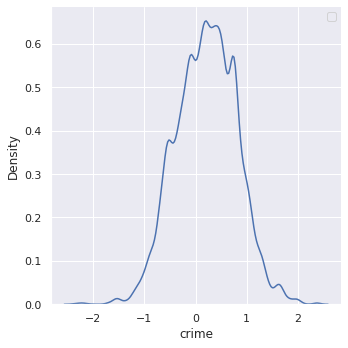

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.displot(data = embeddings, x = "crime", kind='kde')
plt.legend(loc='upper right')

In [26]:
embeddings.shape

(36716, 19)

(36716, 19)

#### 1.5. Train Test Split

In [27]:
from sklearn.model_selection import train_test_split

train_df,test_df = train_test_split(embeddings[['image_location','crime']], 
                                    test_size=0.2, random_state=251238730)


# 2. Creating the VGG Model

In [28]:
import numpy as np  
import h5py as h5py
import PIL

# Others
import numpy as np
from sklearn.model_selection import train_test_split

# For AUC estimation and ROC plots
from sklearn.metrics import roc_curve, auc

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### 2.1. Creating the model

In [29]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
model = VGG16(weights = 'imagenet',      # The weights from the ImageNet competition
              include_top = False,       # Do not include the top layer, which classifies.
              input_shape= (224, 224, 3) # Input shape. Three channels, and BGR (NOT RGB!!!)
             )

58900480/58889256 [==============================] - 0s 0us/step


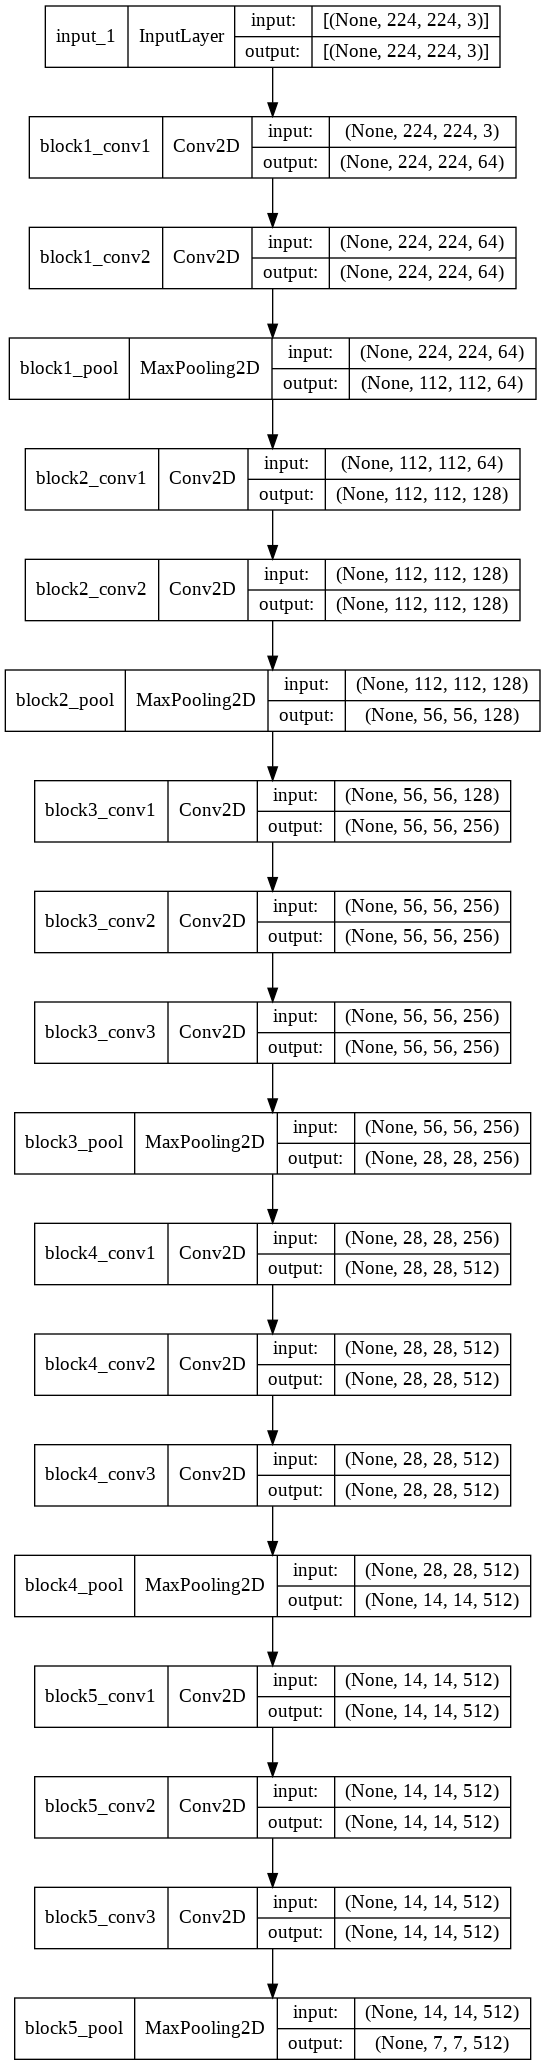

In [30]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, show_shapes=True, show_layer_names=True, to_file='GraphModel.png')
Image(retina=True, filename='GraphModel.png')

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

In [34]:
# Create new model
CBModel = Sequential()

# Copy the layers to our new model. This needs to be done as there is a bug in Keras.
for layer in model.layers:
    CBModel.add(layer)

# Set the layers as untrainable
for layer in CBModel.layers:
    layer.trainable = False

In [35]:
CBModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [36]:
# Set layer as trainable.
# CBModel.layers[14].trainable = True
CBModel.layers[15].trainable = True
CBModel.layers[16].trainable = True

In [37]:
# We now add the new layers for prediction - since the index can be negative we use a linear activation
CBModel.add(Flatten(input_shape=model.output_shape[1:]))
CBModel.add(Dense(128, activation = 'relu'))
CBModel.add(Dropout(0.6))
CBModel.add(Dense(128, activation = 'relu'))
CBModel.add(Dropout(0.6))
CBModel.add(Dense(64, activation = 'relu'))
CBModel.add(Dropout(0.6))
CBModel.add(Dense(1, activation = 'linear'))

In [38]:
CBModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [39]:
# Compiling the model!
import tensorflow.keras as keras
opt = optimizers.Adam(learning_rate=1e-6            # Learning rate needs to be tweaked for convergence and be small!
                      ) 
CBModel.compile(loss='mse', # This is a regression problem!
              optimizer=opt,
              metrics=[keras.metrics.MeanSquaredError()]
              )

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-c8ba2183-0d09-30c3-a951-813e70b5fab4)


#### 2.2. Creating the data generator

In [ ]:
# prepare data augmentation configuration. One for train, one for test.
train_datagen = ImageDataGenerator(
                                  rescale=1./255,                         # NNets like small inputs. Rescale.
                                  shear_range=0.2,                          # Shear?
                                  zoom_range=0.2,                           # Zoom? 0.2 means from 80% to 120%
                                  horizontal_flip=True,                     # Flip horizontally?
                                  vertical_flip=True,                      # Flip vertically?
                                  preprocessing_function=preprocess_input,  # VGG expects specific input. Set it up with this function that comes prepackaged.
                                  validation_split = 0.2                   # Create a validation cut?
                                  )

test_datagen = ImageDataGenerator(
                                  rescale=1./255,                       # NNets like small inputs. Rescale.
                                  shear_range=0,                          # Shear?
                                  zoom_range=0,                           # Zoom? 0.2 means from 80% to 120%
                                  horizontal_flip=False,                  # Flip horizontally?
                                  vertical_flip=False,                    # Flip vertically?
                                  preprocessing_function=preprocess_input,# VGG expects specific input. Set it up with this function that comes prepackaged.
                                  validation_split = 0                    # No validation cut for test.
                                  )


# We will use a batch size of 64. Depends on RAM of GPU.
batch_size = 128


# VGG requires 224 x 224 images.
(img_height, img_width) = (224, 224)

train_generator = train_datagen.flow_from_dataframe(
                                                    train_df,                      # Where are the pics
                                                    x_col='image_location', 
                                                    y_col='crime',
                                                    target_size=(img_height, img_width), # What size should they be
                                                    batch_size=batch_size,               # Size of batch
                                                    class_mode='raw',            # Class mode, whether 'binary' or 'categorical'
                                                    subset = 'training',                 # What subset to use?
                                                    shuffle = True,                       # Shuffle the data?
                                                    interpolation='bilinear'
                                                    )

validation_generator = train_datagen.flow_from_dataframe(
                                                    train_df,                      # Where are the pics
                                                    x_col='image_location', 
                                                    y_col='crime',
                                                    target_size=(img_height, img_width), # What size should they be
                                                    batch_size=batch_size,               # Size of batch
                                                    class_mode='raw',            # Class mode, whether 'binary' or 'categorical'
                                                    subset = 'validation',               # What subset to use?
                                                    shuffle = True,                       # Shuffle the data?
                                                    interpolation='bilinear'
                                                    )

# Test data generator.
test_generator = test_datagen.flow_from_dataframe(
                                                  test_df,                      # Where are the pics
                                                  x_col='image_location', 
                                                  y_col='crime',                                                  
                                                  target_size=(img_height, img_width),
                                                  batch_size=1, # Pass images one-by-one
                                                  class_mode='raw',
                                                  shuffle = False, # Test set does NOT shuffle the data.
                                                  interpolation='bilinear'
                                                  )

Found 23498 validated image filenames.
Found 5874 validated image filenames.
Found 7344 validated image filenames.


In [ ]:
epochs = 20

# Train!
CBModel.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            steps_per_epoch = 64, # Usually cases / batch_size = 176. Reduced to 32 so it runs faster.
            validation_steps = 32 # Number of validation steps. Again cases / batch_size = 44.
          )




Epoch 1/20
64/64 [==============================] - 279s 4s/step - loss: 1.6310 - mean_squared_error: 1.6310 - val_loss: 0.4096 - val_mean_squared_error: 0.4096
Epoch 2/20
64/64 [==============================] - 146s 2s/step - loss: 1.1210 - mean_squared_error: 1.1210 - val_loss: 0.4010 - val_mean_squared_error: 0.4010
Epoch 3/20
64/64 [==============================] - 147s 2s/step - loss: 0.8317 - mean_squared_error: 0.8317 - val_loss: 0.4022 - val_mean_squared_error: 0.4022
Epoch 4/20
64/64 [==============================] - 147s 2s/step - loss: 0.6248 - mean_squared_error: 0.6248 - val_loss: 0.3983 - val_mean_squared_error: 0.3983
Epoch 5/20
64/64 [==============================] - 147s 2s/step - loss: 0.5271 - mean_squared_error: 0.5271 - val_loss: 0.3892 - val_mean_squared_error: 0.3892
Epoch 6/20
64/64 [==============================] - 147s 2s/step - loss: 0.4781 - mean_squared_error: 0.4781 - val_loss: 0.3921 - val_mean_squared_error: 0.3921
Epoch 7/20
64/64 [================

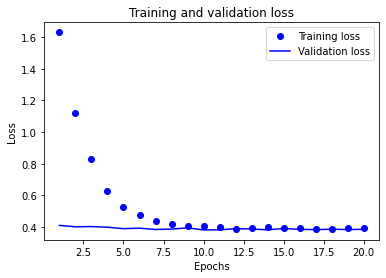

In [ ]:
loss = CBModel.history.history['loss']
val_loss = CBModel.history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Saving the model
CBModel.save('/content/drive/MyDrive/BankingA3data/models/VGG16_FM9528A_251238730.h5')

In [40]:
CBModel = keras.models.load_model('/content/drive/MyDrive/BankingA3data/models/VGG16_FM9528A_251238730.h5')

In [ ]:
# !mkdir /content/drive/MyDrive/BankingA3data/models
# !mkdir '/content/drive/MyDrive/BankingA3data/model_insights'


# 3. Creating the Resnet Model

In [91]:
import numpy as np
from sklearn.model_selection import train_test_split

# For AUC estimation and ROC plots
from sklearn.metrics import roc_curve, auc

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Image and directories
import cv2
import os

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow import keras

In [92]:
# Import base model. Using ResNet50v2.
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

# Import model with input layer
base_model = ResNet50V2(weights = 'imagenet',     # The weights from the ImageNet competition
                      include_top = False,       # Do not include the top layer, which classifies.
                      input_shape= (224, 224, 3) # Input shape. Three channels.
                      )

94683136/94668760 [==============================] - 1s 0us/step


In [102]:
# Set the base model to untrainable.
base_model.trainable = False

In [103]:
# Parameters
ImageSize = (224,224)
BatchSize = 128

In [104]:
# Create the full model using the Model API

# Input layer
inputs = keras.Input(shape=ImageSize + (3,),
                        name = 'image_only_input')

# Add the ResNet model, setting it to be untrainable. 
# First we store it on a temporary variable.
x = base_model(inputs, training=False)

# Flatten to make it the same size as the original model
x = Flatten()(x)

# Now we actually add it to a layer. Note the way of writing it.
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

# Add final output layer.
outputs = Dense(1, activation='linear')(x)

# Create the complete model object
ResnetModel = keras.Model(inputs, outputs)

In [105]:
# This is what the model looks like now.
ResnetModel.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_only_input (InputLaye  [(None, 224, 224, 3)]    0         
 r)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_9 (Dense)             (None, 64)                6422592   
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                                           

In [106]:
# Compiling the model! Note the learning rate.
opt = optimizers.Adam(learning_rate=1e-6            # Learning rate needs to be tweaked for convergence and be small!
                      ) 
ResnetModel.compile(loss='mse', # This is NOT a classification problem!
                      optimizer=opt
                       )

In [107]:
# Define parameters

target_size = (224, 224)
batch_size = 128
DataDir = 'LIDAR'

# Define generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                                  rescale=None,                         # Inputs are scaled in the preprocessing function
                                  shear_range=0,                          # Shear?
                                  zoom_range=0,                           # Zoom? 0.2 means from 80% to 120%
                                  horizontal_flip=True,                     # Flip horizontally?
                                  vertical_flip=True,                      # Flip vertically?
                                  preprocessing_function=preprocess_input,  # ResNet expects specific input. Set it up with this function that comes prepackaged.
                                  validation_split = 0.2                    # Create a validation cut?
                                  )

test_datagen = ImageDataGenerator(
                                  rescale=None,                        # Inputs are scaled in the preprocessing function
                                  shear_range=0,                          # Shear?
                                  zoom_range=0,                           # Zoom? 0.2 means from 80% to 120%
                                  horizontal_flip=False,                     # Flip horizontally?
                                  vertical_flip=False,                      # Flip vertically?
                                  preprocessing_function=preprocess_input,  # VGG expects specific input. Set it up with this function that comes prepackaged.
                                  )

# Point to the data and **give the targets**. Note the "raw" class_mode
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='image_location',   # Path to images
                                                    y_col='crime',  # Target
                                                    target_size=target_size, # Same as last lab
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='raw',
                                                    subset='training',
                                                    interpolation="bilinear"
                                                   )

validation_generator = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='image_location',
                                                    y_col='crime',
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='raw',
                                                    subset='validation',
                                                    interpolation="bilinear"
                                                   )

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  x_col='image_location',
                                                  y_col='crime',
                                                  target_size=target_size,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='raw',
                                                  interpolation="bilinear"
                                                  )

Found 23498 validated image filenames.
Found 5874 validated image filenames.
Found 7344 validated image filenames.


### Model Warm Up

In [109]:
# Number of epochs
epochs = 2

# Train!
ResnetModel.fit(
                  train_generator,
                  epochs=epochs,
                  validation_data=validation_generator,
                  steps_per_epoch = 64, # Usually cases / batch_size = 3.
                  validation_steps = 32 # Number of validation steps. Again cases / batch_size = 1.
                  )


Epoch 1/2
64/64 [==============================] - 55s 864ms/step - loss: 3.8531 - val_loss: 0.5757
Epoch 2/2
64/64 [==============================] - 48s 752ms/step - loss: 2.5987 - val_loss: 0.5011


#### Model training

In [110]:
base_model.trainable = True
# Recompile as we changed things.
ResnetModel.compile(loss='mse',
                      optimizer=opt
                       )


In [111]:
# Define callbacks
my_callbacks = [
    # Save the weights of the best performing model to the checkpoint folder.
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                     min_delta=0.000001,
                                     patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/BankingA3data/models/checkpoint/model.{epoch:02d}-{val_loss:.2f}.h5',
                                       save_best_only=True,
                                       save_weights_only=True),
]

# Number of epochs
epochs = 20

# Train!
ResnetModel.fit(
                  train_generator, # Pass the train generator
                  epochs=epochs, # Pass the epochs
                  validation_data=validation_generator, # Pass the validation generator
                  steps_per_epoch = 64,  # Usually cases / batch_size = 3.
                  validation_steps = 32  # Number of validation steps. Again cases / batch_size = 
                  )

Epoch 1/20
64/64 [==============================] - 64s 906ms/step - loss: 1.3893 - val_loss: 0.4396
Epoch 2/20
64/64 [==============================] - 58s 900ms/step - loss: 0.8309 - val_loss: 0.4145
Epoch 3/20
64/64 [==============================] - 62s 967ms/step - loss: 0.6355 - val_loss: 0.4033
Epoch 4/20
64/64 [==============================] - 62s 971ms/step - loss: 0.5530 - val_loss: 0.4018
Epoch 5/20
64/64 [==============================] - 62s 960ms/step - loss: 0.5048 - val_loss: 0.4010
Epoch 6/20
64/64 [==============================] - 58s 897ms/step - loss: 0.4885 - val_loss: 0.4084
Epoch 7/20
64/64 [==============================] - 57s 895ms/step - loss: 0.4566 - val_loss: 0.4012
Epoch 8/20
64/64 [==============================] - 62s 962ms/step - loss: 0.4423 - val_loss: 0.3902
Epoch 9/20
64/64 [==============================] - 58s 897ms/step - loss: 0.4397 - val_loss: 0.4049
Epoch 10/20
64/64 [==============================] - 57s 893ms/step - loss: 0.4120 - val_lo

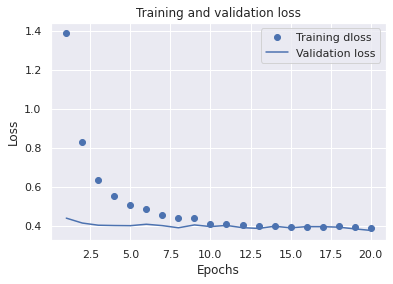

In [112]:
# Plotting training history.
loss = ResnetModel.history.history['loss']
val_loss = ResnetModel.history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training dloss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/BankingA3data/model_insights/resnet_model.pdf')
plt.show()

In [113]:
# Saving the model
ResnetModel.save('/content/drive/MyDrive/BankingA3data/models/resnet_FM9528A_251238730_v2.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [132]:
from tensorflow import keras
ResnetModel = keras.models.load_model('/content/drive/MyDrive/BankingA3data/models/resnet_FM9528A_251238730_v2.h5')

# 4. Visualizing the learning Process 

In [41]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [42]:
testing_images = test_df.sample(10)
testing_images = testing_images.merge(embeddings[['image_location','SOAC11NM','LACNM']],on='image_location',how='left')
testing_images[['image_location','crime','LACNM','SOAC11NM']]

,image_location,crime,LACNM,SOAC11NM
0,LIDAR/LIDAR_38857.png,0.014,Ethnically Diverse Metropolitan Living,Urban cultural mix
1,LIDAR/LIDAR_19003.png,0.091,Rural-Urban Fringe,Households in terraces and flats
2,LIDAR/LIDAR_55372.png,0.829,Ethnically Diverse Metropolitan Living,Young ethnic communities
3,LIDAR/LIDAR_44426.png,-0.339,Ethnically Diverse Metropolitan Living,Urban cultural mix
4,LIDAR/LIDAR_48807.png,-0.599,Rural-Urban Fringe,Affluent communities
5,LIDAR/LIDAR_29576.png,0.035,Ethnically Diverse Metropolitan Living,Inner city cosmopolitan
6,LIDAR/LIDAR_24597.png,0.618,Ethnically Diverse Metropolitan Living,Asian traits
7,LIDAR/LIDAR_17254.png,0.363,Ethnically Diverse Metropolitan Living,Urban cultural mix
8,LIDAR/LIDAR_39154.png,-0.299,Ethnically Diverse Metropolitan Living,Households in terraces and flats
9,LIDAR/LIDAR_26672.png,-0.283,London Cosmopolitan,Inner city cosmopolitan


In [43]:
# Get the image in the right size
def get_img_array(img_path, size = (224, 224)):
    import tensorflow as tf
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    array = preprocess_input(array)
    return array

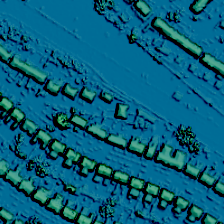

In [88]:
# Get an image
img_path = 'LIDAR/LIDAR_29576.png'
data = get_img_array(img_path)

# Plot it
display(Image(img_path))

In [89]:
preds = CBModel.predict(preprocess_input(data/255))
print(preds)

[[-0.20080917]]


In [80]:
# The explainer. Gotten from https://keras.io/examples/vision/grad_cam/
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names):
    from tensorflow import keras
    import tensorflow as tf
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [81]:
# Set the layers.
last_conv_layer_name = "block5_conv3"
classifier_layer_names =  ["block5_pool", 
                           "flatten_8",
                           "dense_40",
                           "dense_41",
                           "dense_42",
                           "dense_43",
                           "dense_44"]


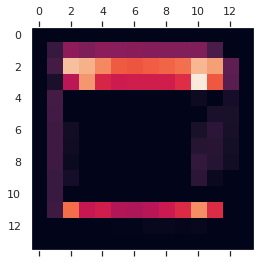

In [90]:
# Plot the heatmap!
heatmap = make_gradcam_heatmap(
    preprocess_input(data/255), CBModel, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.grid(None)
plt.show()

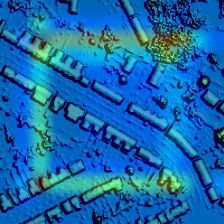

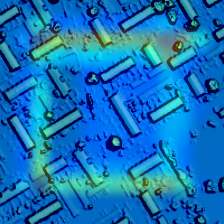

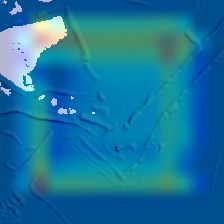

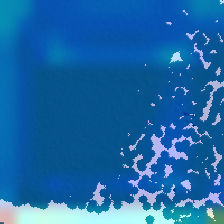

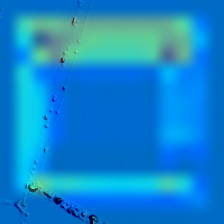

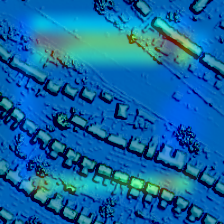

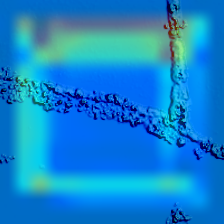

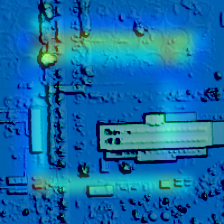

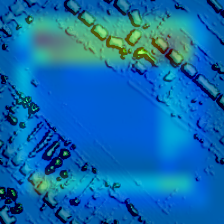

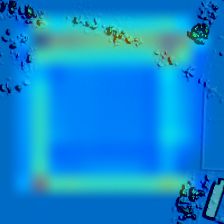

In [119]:
#for all 10
for i in testing_images['image_location']:
    img_path = i
    data = get_img_array(i)
    heatmap = make_gradcam_heatmap(
    preprocess_input(data/255), CBModel, last_conv_layer_name, classifier_layer_names)
      # We load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    name = i.split('/')[-1]
    save_path = "output_gradcam/"+name
    superimposed_img.save(save_path)

    # Display Grad CAM
    display(Image(save_path))


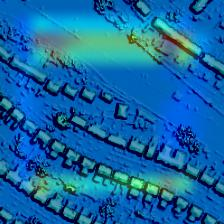

In [91]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "Street_Example.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))


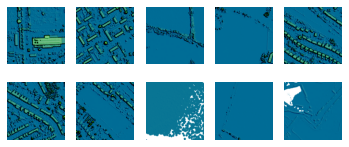

In [128]:

import matplotlib.pyplot as plt
import glob
import math

filenames = sorted(list(testing_images['image_location']))

column_numbers = 5 

# number of columns (width) and rows (height)
w = column_numbers
h = math.ceil(len(filenames) / column_numbers)

# create places for images
fig, axs = plt.subplots(h, w)

# remove axis for every image
for row in axs:
    for ax in row:
        ax.axis('off')


# display image
for i, name in enumerate(filenames):
    
    # calculate position 
    col = i % column_numbers
    row = i // column_numbers

    # read image
    img = plt.imread(name)
    
    # display image
    axs[row][col].imshow(img)
    
plt.subplots_adjust(bottom=0.2, top=0.7, hspace=0.1)
# save in file - it has to be before `show()`
plt.savefig('image_input.jpg',dpi=500)


# display all 
plt.show()

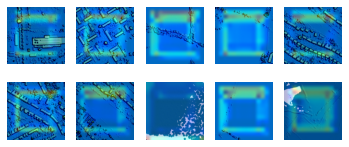

In [129]:
import matplotlib.pyplot as plt
import glob
import math


filenames = sorted(glob.glob('output_gradcam/*.png'))

column_numbers = 5 

# number of columns (width) and rows (height)
w = column_numbers
h = math.ceil(len(filenames) / column_numbers)

# create places for images
fig, axs = plt.subplots(h, w)

# remove axis for every image
for row in axs:
    for ax in row:
        ax.axis('off')


# display image
for i, name in enumerate(filenames):
    
    # calculate position 
    col = i % column_numbers
    row = i // column_numbers

    # read image
    img = plt.imread(name)
    
    # display image
    axs[row][col].imshow(img)
    
plt.subplots_adjust(bottom=0.2, top=0.7, hspace=0.1)
# save in file - it has to be before `show()`
plt.savefig('image_output.jpg',dpi=500)


# display all 
plt.show()

# 5. Prediction of the Index

In [130]:
preds_VGG = []
for i in list(test_df['image_location']):
  data = get_img_array(i)
  preds_VGG.append(CBModel.predict(preprocess_input(data/255)))

test_df['preds_VGG_crime'] = preds_VGG

In [157]:
preds_resnet = []
for i in list(test_df['image_location']):
  data = get_img_array(i)
  preds_resnet.append(ResnetModel.predict(preprocess_input(data/255)))

In [155]:
test_df['preds_resnet_crime'] = preds_resnet

In [156]:
test_df.sample(5)

,image_location,crime,preds_VGG_crime,preds_resnet_crime
22069,LIDAR/LIDAR_52162.png,0.582,[[-0.16805209]],-1.988790
15719,LIDAR/LIDAR_40243.png,0.799,[[-0.18027596]],-2.195050
21878,LIDAR/LIDAR_7007.png,0.110,[[-0.20959021]],-2.506370
6687,LIDAR/LIDAR_31039.png,0.109,[[-0.19985466]],-1.639563
8251,LIDAR/LIDAR_57653.png,-0.079,[[-0.2016922]],-1.908277
